### Read in data
TODO: Update the path to point to a concatenated version of the padmapper data

In [1]:
import pandas as pd
# Could update this to be all the padmapper data
padmapper_path = "PadmapperData/Padmapper2025.xlsx"
df = pd.read_excel(padmapper_path)

In [2]:
import numpy as np

# Divide Price by number of Beds since in padmapper it is standardized
df["StdPrice"] = np.where(
    df["Bed"] > 0,
    df["Price"] / df["Bed"],
    df["Price"]  # for studios, just use total SqFt since we can't divide by 0
)

### Rent vs Square Feet

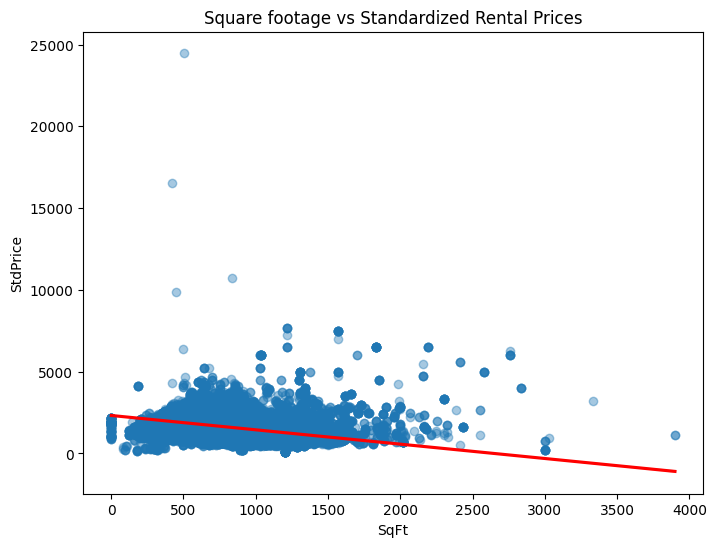

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.regplot(data=df, x="SqFt", y="StdPrice", scatter_kws={'alpha':0.4}, line_kws={"color":"red"})
plt.title("Square footage vs Standardized Rental Prices")
plt.show()

In [4]:
from scipy import stats

# Standardized SqFt
slope, intercept, r_value, p_value, std_err = stats.linregress(df["SqFt"], df["StdPrice"])
print("\nSqFt → Standardized Rent")
print(f"Line: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}, p = {p_value:.4e}")



SqFt → Standardized Rent
Line: y = -0.88x + 2324.96
R² = 0.1211, p = 0.0000e+00


### Examining Amenities
Padmapper doesn't have parking in the data, will likely use entrata data for that

In [5]:
# Amenity Columns
amenity_cols = [
    "Fitness Center", "Swimming Pool", "In Unit Laundry"
]

# Calculate average rent for units with vs. without each amenity
amenity_summary = {}
for col in amenity_cols:
    amenity_summary[col] = df.groupby(col)["Price"].mean()

amenity_df = pd.DataFrame(amenity_summary).T
amenity_df.columns = ["No Amenity Avg Rent", "Amenity Avg Rent"]
amenity_df

,No Amenity Avg Rent,Amenity Avg Rent
Fitness Center,2135.057962,2478.897002
Swimming Pool,2194.653326,2571.099862
In Unit Laundry,2111.528633,2483.900806


### Run T-test to calculate if difference in means is statistically significant

In [6]:
t_test_results = []

for col in amenity_cols:
    group0 = df.loc[df[col] == 0, "Price"]
    group1 = df.loc[df[col] == 1, "Price"]
    
    # t-test (does not assume equal variance)
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False, nan_policy="omit")
    
    t_test_results.append({
        "Amenity": col,
        "Mean Rent (No)": group0.mean(),
        "Mean Rent (Yes)": group1.mean(),
        "Difference": group1.mean() - group0.mean(),
        "t-statistic": t_stat,
        "p-value": p_val
    })

t_test_df = pd.DataFrame(t_test_results).set_index("Amenity")
t_test_df


,Mean Rent (No),Mean Rent (Yes),Difference,t-statistic,p-value
Amenity,,,,,
Fitness Center,2135.057962,2478.897002,343.839040,-71.148916,0.0
Swimming Pool,2194.653326,2571.099862,376.446536,-68.590567,0.0
In Unit Laundry,2111.528633,2483.900806,372.372174,-78.738453,0.0


From above, it seems that fitness center (gym), pool, and laundry yielded higher average rental income than their counterparts which do not have these

### Examining Building Age

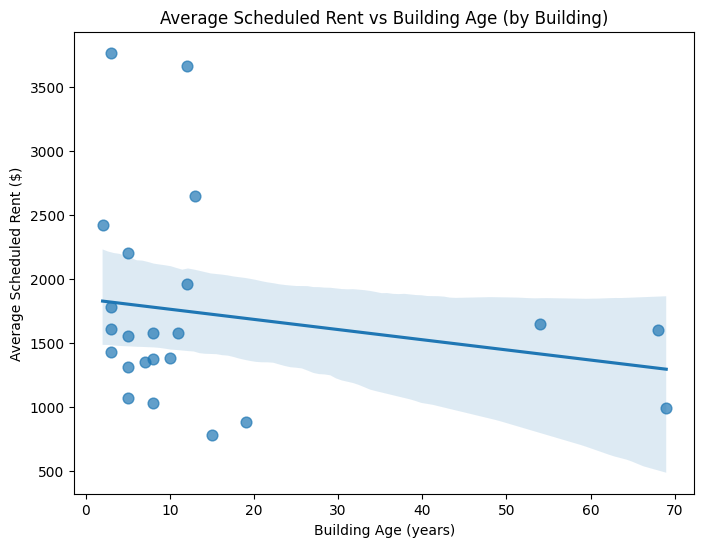

(                      Building  Age      AvgRent
 0                    17Hundred   15   779.145900
 1                      1Eleven   10  1385.081838
 2                1Ten_on_Whyte   69   988.629479
 3                     308_King    2  2418.006011
 4                    417Nelson    7  1350.840376
 5         ALMA_@_ByWard_Market    3  1777.134988
 6                ALMA_@_Guelph    3  1607.602552
 7                ALMA_@_Oshawa    5  1556.166711
 8   ALMA_@_Shaughnessy_Village    3  1431.624756
 9          ALMA_Latin_Quartier    5  2203.448942
 10             ALMA_Sandy_Hill   68  1601.865562
 11            Bridgeport_House   12  1957.067392
 12                Fergus_House    8  1027.493853
 13              Hespeler_House    5  1309.880469
 14          King_Street_Towers   12  3666.645987
 15             MyRez_on_Lester   11  1578.409727
 16               Preston_House   13  2644.927276
 17                    See-More    3  3766.976549
 18                     The_Arc    5  1066.253998


In [12]:
import os
from glob import glob

directory = os.getcwd()
files = os.listdir("Properties_Cleaned_Rent")
building_stats = []
for file in files:
    df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
    df_temp = df_temp.dropna(subset=["Scheduled Rent", "Property Year Built"])
    df_temp = df_temp[df_temp["Scheduled Rent"] > 0]
    age = 2025 - df_temp["Property Year Built"].iloc[0]
    avg_rent = df_temp["Scheduled Rent"].mean()
    building_name = os.path.basename(file).replace("_filtered_output.csv", "")
    building_stats.append({"Building": building_name, "Age": age, "AvgRent": avg_rent})

building_stats_df = pd.DataFrame(building_stats)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    building_stats_df["Age"], building_stats_df["AvgRent"]
)

regression_results = {
    "Line": f"Rent = {slope:.2f} * Age + {intercept:.2f}",
    "R²": r_value**2,
    "p-value": p_value
}

plt.figure(figsize=(8,6))
sns.regplot(data=building_stats_df, x="Age", y="AvgRent", scatter_kws={'s':60, 'alpha':0.7})
plt.title("Average Scheduled Rent vs Building Age (by Building)")
plt.xlabel("Building Age (years)")
plt.ylabel("Average Scheduled Rent ($)")
plt.show()

building_stats_df, regression_results

### Number of beds vs rent

                            OLS Regression Results                            
Dep. Variable:      Price per Bedroom   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     13.60
Date:                Thu, 21 Aug 2025   Prob (F-statistic):            0.00951
Time:                        19:28:02   Log-Likelihood:                -55.459
No. Observations:                   8   AIC:                             116.9
Df Residuals:                       5   BIC:                             117.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2018.3191    264.018      7.645      0.0

C:\Users\JackE\AppData\Local\Temp\ipykernel_23948\1061168357.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Equation": f"Rent = {model_poly.params[1]:.2f}*Beds + {model_poly.params[2]:.2f}*Beds^2 + {model_poly.params[0]:.2f}",


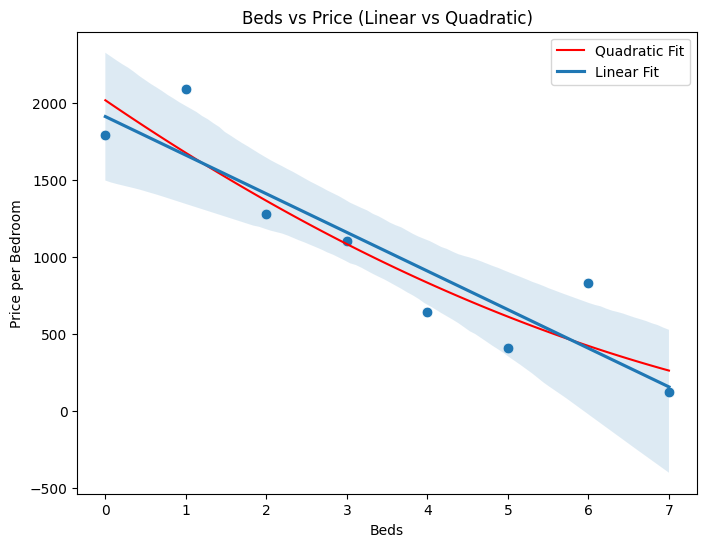

,Model,Line,R²,p-value,Equation,p-values
0,Linear,Rent = -250.60 * Age + 1912.45,0.832563,0.00157,NaN,NaN
1,Quadratic,NaN,0.844693,NaN,Rent = -356.48*Beds + 15.12*Beds^2 + 2018.32,"{'const': 0.0006095746679458775, 'x1': 0.09896..."


In [13]:
import statsmodels.api as sm
# Drop na's and take non-zero price
df_beds = df.dropna(subset=["Bed", "Price"])
df_beds = df_beds[df_beds["Price"] > 0]

# Standardize price
df_beds["Price per Bedroom"] = np.where(df_beds["Bed"] > 0, df_beds["Price"] / df_beds["Bed"], df_beds["Price"])

# Take the average based on the amount of beds
avg_per_bed = df_beds.groupby("Bed")["Price per Bedroom"].mean().reset_index()

# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    avg_per_bed["Bed"], avg_per_bed["Price per Bedroom"]
)

regression_results = {
    "Line": f"Rent = {slope:.2f} * Age + {intercept:.2f}",
    "R²": r_value**2,
    "p-value": p_value
}

X = avg_per_bed["Bed"]
y = avg_per_bed["Price per Bedroom"]

X_poly = np.column_stack((X, X**2))
X_poly = sm.add_constant(X_poly) 
model_poly = sm.OLS(y, X_poly).fit()
print(model_poly.summary())

# Quadratic Regression
regression_results_poly = {
    "Equation": f"Rent = {model_poly.params[1]:.2f}*Beds + {model_poly.params[2]:.2f}*Beds^2 + {model_poly.params[0]:.2f}",
    "R²": model_poly.rsquared,
    "p-values": model_poly.pvalues.to_dict()
}

plt.figure(figsize=(8,6))
sns.scatterplot(x=X, y=y, s=60)

x_range = np.linspace(X.min(), X.max(), 100)
y_pred = model_poly.predict(sm.add_constant(np.column_stack((x_range, x_range**2))))
plt.plot(x_range, y_pred, color="red", label="Quadratic Fit")

sns.regplot(data=avg_per_bed, x="Bed", y="Price per Bedroom", scatter=False, label="Linear Fit")

plt.title("Beds vs Price (Linear vs Quadratic)")
plt.xlabel("Beds")
plt.ylabel("Price per Bedroom")
plt.legend()
plt.show()

results_df = pd.DataFrame([
    {"Model": "Linear", **regression_results},
    {"Model": "Quadratic", **regression_results_poly}
])

display(results_df)


### Bedrooms and Bathrooms

In [14]:
df_beds = df.dropna(subset=["Bed", "Bath", "Price"])
df_beds = df_beds[df_beds["Price"] > 0]

df_beds["Price per Bedroom"] = np.where(
    df_beds["Bed"] > 0,
    df_beds["Price"] / df_beds["Bed"],
    df_beds["Price"]
)

y = df_beds["Price per Bedroom"]
X = df_beds[["Bed", "Bath"]]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Price per Bedroom   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                 1.969e+04
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        19:28:13   Log-Likelihood:            -8.4843e+05
No. Observations:              110219   AIC:                         1.697e+06
Df Residuals:                  110216   BIC:                         1.697e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2219.9007      4.750    467.392      0.0

In [15]:
# Add squared terms
df_beds["Bed^2"] = df_beds["Bed"]**2
df_beds["Bath^2"] = df_beds["Bath"]**2

X_quad = df_beds[["Bed", "Bath", "Bed^2", "Bath^2"]]
X_quad = sm.add_constant(X_quad)

model_quad = sm.OLS(y, X_quad).fit()
print(model_quad.summary())


                            OLS Regression Results                            
Dep. Variable:      Price per Bedroom   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                 1.172e+04
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        19:28:17   Log-Likelihood:            -8.4573e+05
No. Observations:              110219   AIC:                         1.691e+06
Df Residuals:                  110214   BIC:                         1.692e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2472.8978     16.901    146.316      0.0

In [16]:
df_beds["Bed*Bath"] = df_beds["Bed"] * df_beds["Bath"]

X_inter = df_beds[["Bed", "Bath", "Bed*Bath"]]
X_inter = sm.add_constant(X_inter)

model_inter = sm.OLS(y, X_inter).fit()
print(model_inter.summary())


                            OLS Regression Results                            
Dep. Variable:      Price per Bedroom   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                 1.315e+04
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        19:28:20   Log-Likelihood:            -8.4840e+05
No. Observations:              110219   AIC:                         1.697e+06
Df Residuals:                  110215   BIC:                         1.697e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2316.7830     13.787    168.038      0.0

### Total number of units vs Price, and Floors per price
Need to manually find out how many floors are in each building since csv data does not tell us this
Unsure how to handle buildings that are "split" into two

<Axes: xlabel='Count', ylabel='AvgRent'>

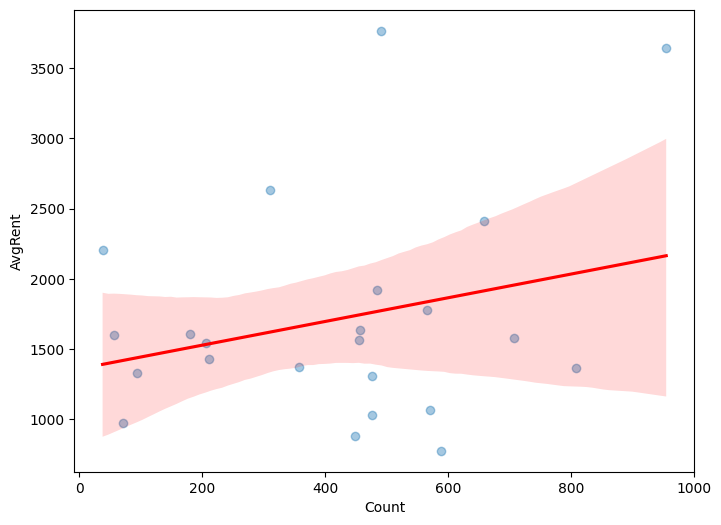

In [ ]:
plt.figure(figsize=(8,6))
sns.regplot(data=building_counts_df, x="Count", y="AvgRent", scatter_kws={'alpha':0.4}, line_kws={"color":"red"})